# ROP Detection - Hyperparameter Experimentation Notebook

This notebook allows you to experiment with:
- **CLAHE clip limits** and tile grid sizes
- **Learning rate** and optimizer settings
- **Batch size** and model architecture
- **Data augmentation** strategies
- **Loss function** configurations

Each experiment is logged for comparison.

## 1. Setup and Imports

In [2]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, ReduceLROnPlateau
from torchvision import transforms, models
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix

# Set project root
PROJECT_ROOT = Path(os.getcwd())
print(f"Project Root: {PROJECT_ROOT}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Project Root: c:\Users\HP\Desktop\ROPDetectionAIML
PyTorch version: 2.5.1+cu121
CUDA available: True
GPU: NVIDIA GeForce GTX 1650


## 2. Configurable CLAHE Transform

In [3]:
class ConfigurableCLAHETransform:
    """
    Configurable CLAHE transform for experimentation.
    
    Parameters:
    - clip_limit: Threshold for contrast limiting (higher = more contrast)
    - tile_grid_size: Size of grid for histogram equalization
    - channel: 'green', 'all', or 'luminance'
    """
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8), channel='green'):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        self.channel = channel
        self.clahe = cv2.createCLAHE(
            clipLimit=clip_limit,
            tileGridSize=tile_grid_size
        )

    def __call__(self, img):
        img = np.array(img)

        if img.ndim == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        if self.channel == 'green':
            # Original approach: use green channel only
            green = img[:, :, 1]
            enhanced = self.clahe.apply(green)
            img = np.stack([enhanced, enhanced, enhanced], axis=2)
            
        elif self.channel == 'all':
            # Apply CLAHE to all RGB channels separately
            r = self.clahe.apply(img[:, :, 0])
            g = self.clahe.apply(img[:, :, 1])
            b = self.clahe.apply(img[:, :, 2])
            img = np.stack([r, g, b], axis=2)
            
        elif self.channel == 'luminance':
            # Apply CLAHE on L channel (LAB color space)
            lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
            lab[:, :, 0] = self.clahe.apply(lab[:, :, 0])
            img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

        return img
    
    def __repr__(self):
        return f"CLAHE(clip={self.clip_limit}, grid={self.tile_grid_size}, channel={self.channel})"

## 3. Configurable Transform Pipeline

In [4]:
def get_configurable_transforms(
    train=True,
    image_size=224,
    clahe_clip_limit=2.0,
    clahe_tile_grid=(8, 8),
    clahe_channel='green',
    use_clahe=True,
    horizontal_flip=True,
    vertical_flip=False,
    rotation_degrees=0,
    color_jitter=None,
    normalize=True
):
    """
    Create a configurable transform pipeline.
    
    Parameters:
    - image_size: Target image size
    - clahe_clip_limit: CLAHE clip limit (try 1.0, 2.0, 3.0, 4.0)
    - clahe_tile_grid: CLAHE tile grid size
    - clahe_channel: 'green', 'all', or 'luminance'
    - use_clahe: Whether to apply CLAHE
    - horizontal_flip: Random horizontal flip (train only)
    - vertical_flip: Random vertical flip (train only)
    - rotation_degrees: Random rotation range
    - color_jitter: Dict with brightness, contrast, saturation, hue
    - normalize: Whether to apply ImageNet normalization
    """
    transform_list = [transforms.Resize((image_size, image_size))]
    
    # Training augmentations
    if train:
        if horizontal_flip:
            transform_list.append(transforms.RandomHorizontalFlip(p=0.5))
        if vertical_flip:
            transform_list.append(transforms.RandomVerticalFlip(p=0.5))
        if rotation_degrees > 0:
            transform_list.append(transforms.RandomRotation(rotation_degrees))
        if color_jitter:
            transform_list.append(transforms.ColorJitter(**color_jitter))
    
    # CLAHE
    if use_clahe:
        transform_list.append(
            ConfigurableCLAHETransform(
                clip_limit=clahe_clip_limit,
                tile_grid_size=clahe_tile_grid,
                channel=clahe_channel
            )
        )
    
    # Convert to tensor
    transform_list.append(transforms.ToTensor())
    
    # Normalization
    if normalize:
        transform_list.append(
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        )
    
    return transforms.Compose(transform_list)

print("Transform pipeline configured!")

Transform pipeline configured!


## 4. Dataset Class

In [5]:
class ROPDataset(Dataset):
    def __init__(self, csv_file, transforms=None):
        self.df = pd.read_csv(csv_file)
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["Source"]
        label = int(row["ROP Label"])

        image = Image.open(img_path).convert("RGB")

        if self.transforms:
            image = self.transforms(image)

        return image, torch.tensor(label, dtype=torch.float32)


# Data paths
TRAIN_CSV = PROJECT_ROOT / "data/splits/train.csv"
VAL_CSV = PROJECT_ROOT / "data/splits/val.csv"
TEST_CSV = PROJECT_ROOT / "data/splits/test.csv"

print(f"Train CSV exists: {TRAIN_CSV.exists()}")
print(f"Val CSV exists: {VAL_CSV.exists()}")
print(f"Test CSV exists: {TEST_CSV.exists()}")

Train CSV exists: True
Val CSV exists: True
Test CSV exists: True


## 5. Model Factory

In [6]:
def get_model(model_name='resnet18', pretrained=True, freeze_backbone=False):
    """
    Get a model for binary classification.
    
    Parameters:
    - model_name: 'resnet18', 'resnet34', 'resnet50', 'efficientnet_b0'
    - pretrained: Use ImageNet pretrained weights
    - freeze_backbone: Freeze all layers except final classifier
    """
    if model_name == 'resnet18':
        model = models.resnet18(pretrained=pretrained)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, 1)
        
    elif model_name == 'resnet34':
        model = models.resnet34(pretrained=pretrained)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, 1)
        
    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=pretrained)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, 1)
        
    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(pretrained=pretrained)
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, 1)
        
    else:
        raise ValueError(f"Unknown model: {model_name}")
    
    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False
        # Unfreeze final layer
        if hasattr(model, 'fc'):
            for param in model.fc.parameters():
                param.requires_grad = True
        elif hasattr(model, 'classifier'):
            for param in model.classifier.parameters():
                param.requires_grad = True
    
    return model

print("Model factory ready!")

Model factory ready!


## 6. Training Functions

In [8]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    all_preds, all_labels = [], []

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return total_loss / len(loader), accuracy


@torch.no_grad()
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_probs, all_preds, all_labels = [], [], []

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device).unsqueeze(1)

        logits = model(imgs)
        loss = criterion(logits, labels)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        total_loss += loss.item()
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    auc = roc_auc_score(all_labels, all_probs)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    
    return {
        'loss': total_loss / len(loader),
        'auc': auc,
        'accuracy': accuracy,
        'f1': f1
    }

print("Training functions ready!")

Training functions ready!


## 7. Experiment Runner

In [9]:
class ExperimentRunner:
    """
    Run and log experiments with different hyperparameters.
    """
    def __init__(self):
        self.results = []
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {self.device}")
    
    def compute_pos_weight(self, csv_path):
        df = pd.read_csv(csv_path)
        n_pos = (df["ROP Label"] == 1).sum()
        n_neg = (df["ROP Label"] == 0).sum()
        return torch.tensor([n_neg / n_pos], dtype=torch.float32)
    
    def run_experiment(
        self,
        experiment_name,
        # CLAHE parameters
        clahe_clip_limit=2.0,
        clahe_tile_grid=(8, 8),
        clahe_channel='green',
        use_clahe=True,
        # Model parameters
        model_name='resnet18',
        pretrained=True,
        freeze_backbone=False,
        # Training parameters
        batch_size=16,
        learning_rate=1e-4,
        optimizer_name='adam',
        weight_decay=0.0,
        epochs=10,
        scheduler_name=None,
        # Augmentation parameters
        image_size=224,
        horizontal_flip=True,
        vertical_flip=False,
        rotation_degrees=0,
        # Loss parameters
        use_pos_weight=True,
        pos_weight_multiplier=1.0,
        # Other
        verbose=True
    ):
        """
        Run a single experiment with the given hyperparameters.
        """
        if verbose:
            print(f"\n{'='*60}")
            print(f"Experiment: {experiment_name}")
            print(f"{'='*60}")
        
        config = {
            'experiment_name': experiment_name,
            'clahe_clip_limit': clahe_clip_limit,
            'clahe_tile_grid': clahe_tile_grid,
            'clahe_channel': clahe_channel,
            'use_clahe': use_clahe,
            'model_name': model_name,
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'optimizer': optimizer_name,
            'weight_decay': weight_decay,
            'epochs': epochs,
            'image_size': image_size,
            'horizontal_flip': horizontal_flip,
            'vertical_flip': vertical_flip,
            'rotation_degrees': rotation_degrees,
        }
        
        # Create transforms
        train_transforms = get_configurable_transforms(
            train=True,
            image_size=image_size,
            clahe_clip_limit=clahe_clip_limit,
            clahe_tile_grid=clahe_tile_grid,
            clahe_channel=clahe_channel,
            use_clahe=use_clahe,
            horizontal_flip=horizontal_flip,
            vertical_flip=vertical_flip,
            rotation_degrees=rotation_degrees
        )
        
        val_transforms = get_configurable_transforms(
            train=False,
            image_size=image_size,
            clahe_clip_limit=clahe_clip_limit,
            clahe_tile_grid=clahe_tile_grid,
            clahe_channel=clahe_channel,
            use_clahe=use_clahe
        )
        
        # Create datasets and loaders
        train_ds = ROPDataset(TRAIN_CSV, train_transforms)
        val_ds = ROPDataset(VAL_CSV, val_transforms)
        
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
        
        # Create model
        model = get_model(model_name, pretrained, freeze_backbone).to(self.device)
        
        # Create optimizer
        if optimizer_name == 'adam':
            optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        elif optimizer_name == 'adamw':
            optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        elif optimizer_name == 'sgd':
            optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
        
        # Create scheduler
        scheduler = None
        if scheduler_name == 'step':
            scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
        elif scheduler_name == 'cosine':
            scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
        elif scheduler_name == 'plateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
        
        # Create loss function
        if use_pos_weight:
            pos_weight = self.compute_pos_weight(TRAIN_CSV).to(self.device) * pos_weight_multiplier
            criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        else:
            criterion = nn.BCEWithLogitsLoss()
        
        # Training loop
        best_auc = 0.0
        best_metrics = {}
        history = {'train_loss': [], 'val_loss': [], 'val_auc': [], 'val_acc': []}
        
        for epoch in range(1, epochs + 1):
            train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, self.device)
            val_metrics = validate(model, val_loader, criterion, self.device)
            
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_metrics['loss'])
            history['val_auc'].append(val_metrics['auc'])
            history['val_acc'].append(val_metrics['accuracy'])
            
            if scheduler:
                if scheduler_name == 'plateau':
                    scheduler.step(val_metrics['auc'])
                else:
                    scheduler.step()
            
            if val_metrics['auc'] > best_auc:
                best_auc = val_metrics['auc']
                best_metrics = val_metrics.copy()
                best_metrics['epoch'] = epoch
            
            if verbose:
                print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | "
                      f"Val Loss: {val_metrics['loss']:.4f} | Val AUC: {val_metrics['auc']:.4f} | "
                      f"Val Acc: {val_metrics['accuracy']:.4f}")
        
        # Store results
        result = {
            **config,
            'best_auc': best_metrics.get('auc', 0),
            'best_accuracy': best_metrics.get('accuracy', 0),
            'best_f1': best_metrics.get('f1', 0),
            'best_epoch': best_metrics.get('epoch', 0),
            'history': history
        }
        self.results.append(result)
        
        if verbose:
            print(f"\n✅ Best AUC: {best_metrics.get('auc', 0):.4f} at epoch {best_metrics.get('epoch', 0)}")
        
        return result
    
    def get_results_df(self):
        """Get results as a DataFrame for comparison."""
        df_data = [{k: v for k, v in r.items() if k != 'history'} for r in self.results]
        return pd.DataFrame(df_data)
    
    def plot_comparison(self):
        """Plot comparison of all experiments."""
        if not self.results:
            print("No results to plot.")
            return
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        for result in self.results:
            name = result['experiment_name']
            history = result['history']
            epochs = range(1, len(history['val_auc']) + 1)
            
            axes[0].plot(epochs, history['val_auc'], label=name, marker='o')
            axes[1].plot(epochs, history['val_loss'], label=name, marker='o')
        
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Validation AUC')
        axes[0].set_title('Validation AUC Comparison')
        axes[0].legend()
        axes[0].grid(True)
        
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Validation Loss')
        axes[1].set_title('Validation Loss Comparison')
        axes[1].legend()
        axes[1].grid(True)
        
        plt.tight_layout()
        plt.show()


# Initialize experiment runner
runner = ExperimentRunner()

Using device: cuda


---
## 8. Visualize CLAHE Effects (Preview Before Training)

Visualize how different CLAHE settings affect the images before running experiments.

Sample image: C:\Users\HP\Desktop\ROPDetectionAIML\data\images\2-4_25Nov\set 4\Input\3968V9\5.jpg


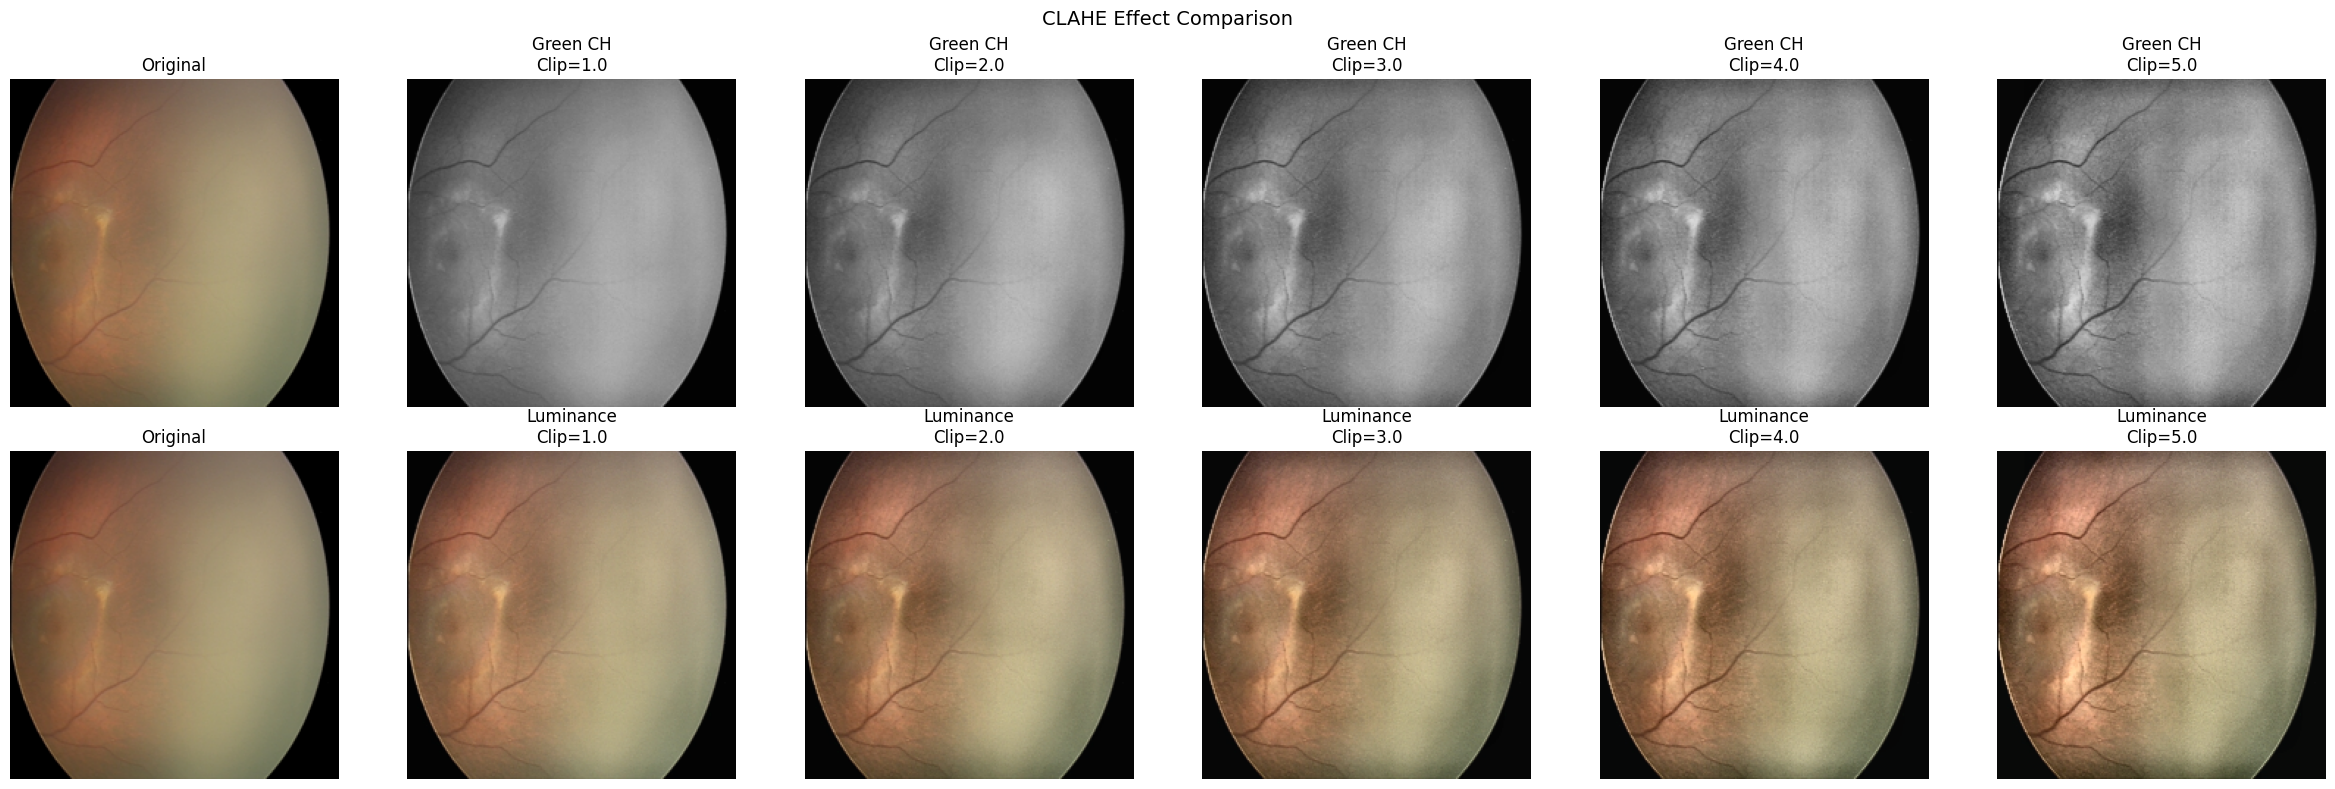

In [10]:
def visualize_clahe_effects(image_path, clip_limits=[1.0, 2.0, 3.0, 4.0, 5.0]):
    """
    Visualize the effect of different CLAHE clip limits on an image.
    """
    img = Image.open(image_path).convert('RGB')
    img_resized = img.resize((224, 224))
    
    fig, axes = plt.subplots(2, len(clip_limits) + 1, figsize=(4 * (len(clip_limits) + 1), 8))
    
    # Original image
    axes[0, 0].imshow(img_resized)
    axes[0, 0].set_title('Original')
    axes[0, 0].axis('off')
    
    axes[1, 0].imshow(img_resized)
    axes[1, 0].set_title('Original')
    axes[1, 0].axis('off')
    
    for i, clip_limit in enumerate(clip_limits):
        # Green channel CLAHE
        clahe_green = ConfigurableCLAHETransform(clip_limit=clip_limit, channel='green')
        img_green = clahe_green(img_resized)
        
        # Luminance CLAHE
        clahe_lum = ConfigurableCLAHETransform(clip_limit=clip_limit, channel='luminance')
        img_lum = clahe_lum(img_resized)
        
        axes[0, i + 1].imshow(img_green)
        axes[0, i + 1].set_title(f'Green CH\nClip={clip_limit}')
        axes[0, i + 1].axis('off')
        
        axes[1, i + 1].imshow(img_lum)
        axes[1, i + 1].set_title(f'Luminance\nClip={clip_limit}')
        axes[1, i + 1].axis('off')
    
    plt.suptitle('CLAHE Effect Comparison', fontsize=14)
    plt.tight_layout()
    plt.show()


# Get a sample image to visualize
train_df = pd.read_csv(TRAIN_CSV)
sample_image_path = train_df.iloc[0]['Source']
print(f"Sample image: {sample_image_path}")

# Visualize CLAHE effects
visualize_clahe_effects(sample_image_path, clip_limits=[1.0, 2.0, 3.0, 4.0, 5.0])

---
## 9. Experiment 1: CLAHE Clip Limit Comparison

Compare different CLAHE clip limits to find the optimal value.

In [11]:
# Experiment with different CLAHE clip limits
# Reduce epochs for quick experimentation

QUICK_EPOCHS = 10  # Use fewer epochs for quick experiments

clip_limits_to_test = [1.0, 2.0, 3.0, 4.0]

for clip_limit in clip_limits_to_test:
    runner.run_experiment(
        experiment_name=f"CLAHE_clip_{clip_limit}",
        clahe_clip_limit=clip_limit,
        epochs=QUICK_EPOCHS,
        verbose=True
    )


Experiment: CLAHE_clip_1.0
Epoch 01 | Train Loss: 0.8545 | Val Loss: 0.6686 | Val AUC: 0.8675 | Val Acc: 0.7558
Epoch 02 | Train Loss: 0.5390 | Val Loss: 0.6873 | Val AUC: 0.8923 | Val Acc: 0.8605
Epoch 03 | Train Loss: 0.4010 | Val Loss: 0.6862 | Val AUC: 0.8716 | Val Acc: 0.8372
Epoch 04 | Train Loss: 0.3075 | Val Loss: 0.7650 | Val AUC: 0.8461 | Val Acc: 0.8023
Epoch 05 | Train Loss: 0.1983 | Val Loss: 0.7708 | Val AUC: 0.8592 | Val Acc: 0.8256
Epoch 06 | Train Loss: 0.1631 | Val Loss: 0.6819 | Val AUC: 0.8930 | Val Acc: 0.8256
Epoch 07 | Train Loss: 0.2444 | Val Loss: 0.7257 | Val AUC: 0.9082 | Val Acc: 0.8605
Epoch 08 | Train Loss: 0.1672 | Val Loss: 0.6745 | Val AUC: 0.8834 | Val Acc: 0.7674
Epoch 09 | Train Loss: 0.1026 | Val Loss: 0.7690 | Val AUC: 0.8627 | Val Acc: 0.8140
Epoch 10 | Train Loss: 0.1531 | Val Loss: 0.6941 | Val AUC: 0.8903 | Val Acc: 0.8140

✅ Best AUC: 0.9082 at epoch 7

Experiment: CLAHE_clip_2.0
Epoch 01 | Train Loss: 0.8664 | Val Loss: 0.7073 | Val AUC: 0.8


CLAHE Clip Limit Comparison Results


,experiment_name,clahe_clip_limit,best_auc,best_accuracy,best_epoch
1,CLAHE_clip_2.0,2.0,0.918565,0.848837,4
3,CLAHE_clip_4.0,4.0,0.917184,0.848837,9
0,CLAHE_clip_1.0,1.0,0.908213,0.860465,7
2,CLAHE_clip_3.0,3.0,0.897861,0.848837,3


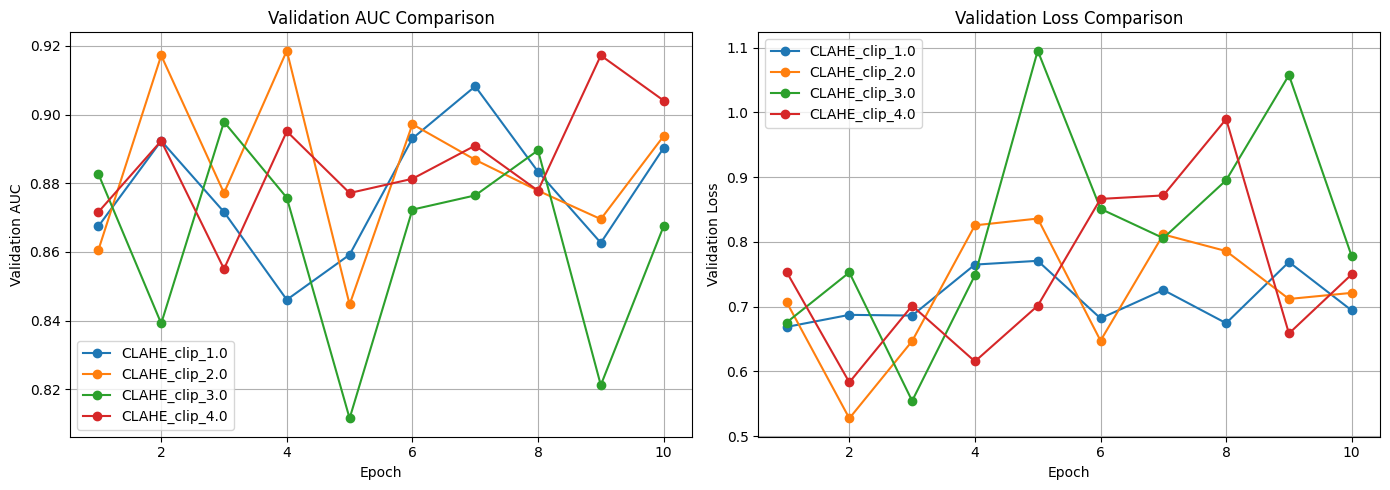

In [12]:
# View results
results_df = runner.get_results_df()
print("\n" + "="*60)
print("CLAHE Clip Limit Comparison Results")
print("="*60)
display(results_df[['experiment_name', 'clahe_clip_limit', 'best_auc', 'best_accuracy', 'best_epoch']].sort_values('best_auc', ascending=False))

# Plot comparison
runner.plot_comparison()

---
## 10. Experiment 2: CLAHE Channel Comparison

Compare different CLAHE channel strategies.

In [13]:
# Reset runner for new experiment set
runner = ExperimentRunner()

channels_to_test = ['green', 'luminance', 'all']

for channel in channels_to_test:
    runner.run_experiment(
        experiment_name=f"CLAHE_channel_{channel}",
        clahe_channel=channel,
        clahe_clip_limit=2.0,  # Use default clip limit
        epochs=QUICK_EPOCHS,
        verbose=True
    )

# Also test without CLAHE
runner.run_experiment(
    experiment_name="No_CLAHE",
    use_clahe=False,
    epochs=QUICK_EPOCHS,
    verbose=True
)

Using device: cuda

Experiment: CLAHE_channel_green
Epoch 01 | Train Loss: 0.8896 | Val Loss: 0.7294 | Val AUC: 0.8841 | Val Acc: 0.8256
Epoch 02 | Train Loss: 0.5170 | Val Loss: 0.6481 | Val AUC: 0.8758 | Val Acc: 0.8256
Epoch 03 | Train Loss: 0.3014 | Val Loss: 0.8305 | Val AUC: 0.8827 | Val Acc: 0.8023
Epoch 04 | Train Loss: 0.2866 | Val Loss: 0.8710 | Val AUC: 0.8378 | Val Acc: 0.8140
Epoch 05 | Train Loss: 0.2724 | Val Loss: 0.8704 | Val AUC: 0.8668 | Val Acc: 0.8372
Epoch 06 | Train Loss: 0.1583 | Val Loss: 0.7139 | Val AUC: 0.8640 | Val Acc: 0.7791
Epoch 07 | Train Loss: 0.1265 | Val Loss: 1.0139 | Val AUC: 0.8447 | Val Acc: 0.8488
Epoch 08 | Train Loss: 0.1076 | Val Loss: 0.7658 | Val AUC: 0.8634 | Val Acc: 0.7907
Epoch 09 | Train Loss: 0.1264 | Val Loss: 1.1173 | Val AUC: 0.8061 | Val Acc: 0.7674
Epoch 10 | Train Loss: 0.1562 | Val Loss: 1.1776 | Val AUC: 0.8068 | Val Acc: 0.7209

✅ Best AUC: 0.8841 at epoch 1

Experiment: CLAHE_channel_luminance
Epoch 01 | Train Loss: 0.8857 

{'experiment_name': 'No_CLAHE',
 'clahe_clip_limit': 2.0,
 'clahe_tile_grid': (8, 8),
 'clahe_channel': 'green',
 'use_clahe': False,
 'model_name': 'resnet18',
 'batch_size': 16,
 'learning_rate': 0.0001,
 'optimizer': 'adam',
 'weight_decay': 0.0,
 'epochs': 10,
 'image_size': 224,
 'horizontal_flip': True,
 'vertical_flip': False,
 'rotation_degrees': 0,
 'best_auc': 0.8674948240165632,
 'best_accuracy': 0.7558139534883721,
 'best_f1': 0.6037735849056604,
 'best_epoch': 9,
 'history': {'train_loss': [0.9416660499572754,
   0.5636066043376923,
   0.3819378882646561,
   0.36012046933174136,
   0.2479575526714325,
   0.16389936000108718,
   0.1848498700559139,
   0.12279205575585365,
   0.12904219198971986,
   0.0830190171673894],
  'val_loss': [0.7949511607487997,
   0.6539599647124609,
   0.7468842963377634,
   0.838349645336469,
   0.7404633102317651,
   0.764956209808588,
   0.7187120094895363,
   0.8801256741086642,
   0.7898728226621946,
   1.1448483740290005],
  'val_auc': [0.80


CLAHE Channel Comparison Results


,experiment_name,clahe_channel,use_clahe,best_auc,best_accuracy
1,CLAHE_channel_luminance,luminance,True,0.890269,0.802326
0,CLAHE_channel_green,green,True,0.884058,0.825581
2,CLAHE_channel_all,all,True,0.878537,0.802326
3,No_CLAHE,green,False,0.867495,0.755814


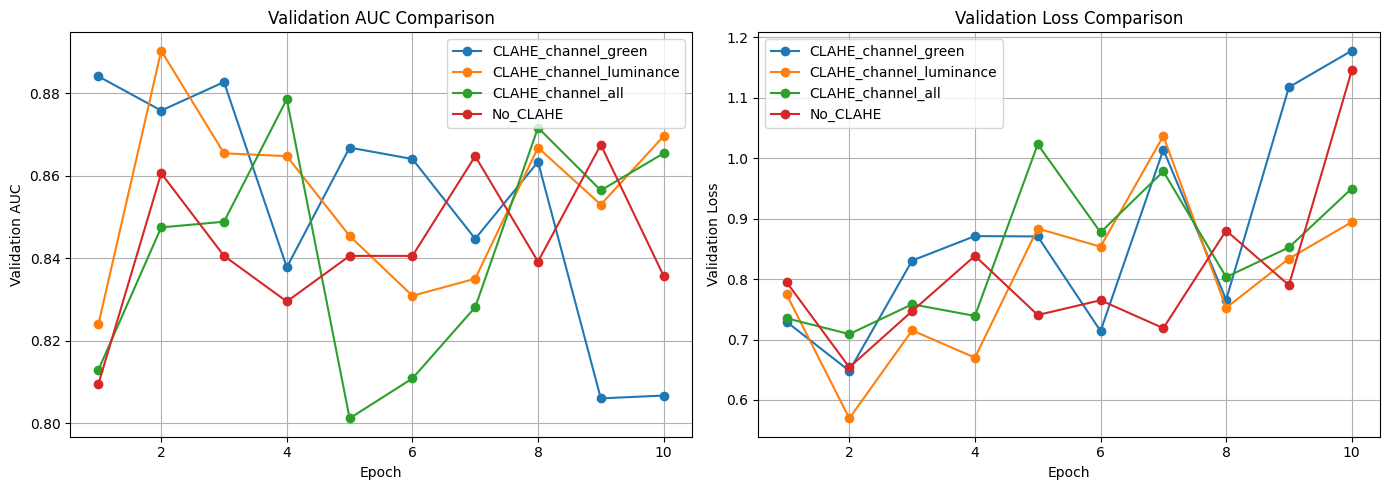

In [14]:
# View results
results_df = runner.get_results_df()
print("\n" + "="*60)
print("CLAHE Channel Comparison Results")
print("="*60)
display(results_df[['experiment_name', 'clahe_channel', 'use_clahe', 'best_auc', 'best_accuracy']].sort_values('best_auc', ascending=False))

runner.plot_comparison()

---
## 11. Experiment 3: Learning Rate Comparison

In [15]:
# Reset runner
runner = ExperimentRunner()

learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]

for lr in learning_rates:
    runner.run_experiment(
        experiment_name=f"LR_{lr}",
        learning_rate=lr,
        epochs=QUICK_EPOCHS,
        verbose=True
    )

Using device: cuda

Experiment: LR_0.001
Epoch 01 | Train Loss: 1.1894 | Val Loss: 1.3943 | Val AUC: 0.5839 | Val Acc: 0.6395
Epoch 02 | Train Loss: 1.0200 | Val Loss: 1.1399 | Val AUC: 0.5418 | Val Acc: 0.6977
Epoch 03 | Train Loss: 0.9315 | Val Loss: 0.9335 | Val AUC: 0.6743 | Val Acc: 0.5814
Epoch 04 | Train Loss: 0.8303 | Val Loss: 1.1028 | Val AUC: 0.6908 | Val Acc: 0.7093
Epoch 05 | Train Loss: 0.8010 | Val Loss: 0.8294 | Val AUC: 0.8164 | Val Acc: 0.6512
Epoch 06 | Train Loss: 0.8210 | Val Loss: 2.9712 | Val AUC: 0.7026 | Val Acc: 0.7674
Epoch 07 | Train Loss: 0.7642 | Val Loss: 0.8255 | Val AUC: 0.7736 | Val Acc: 0.7442
Epoch 08 | Train Loss: 0.7052 | Val Loss: 1.1045 | Val AUC: 0.6929 | Val Acc: 0.7674
Epoch 09 | Train Loss: 0.6351 | Val Loss: 1.2114 | Val AUC: 0.7398 | Val Acc: 0.7326
Epoch 10 | Train Loss: 0.6097 | Val Loss: 2.3766 | Val AUC: 0.6598 | Val Acc: 0.5233

✅ Best AUC: 0.8164 at epoch 5

Experiment: LR_0.0005
Epoch 01 | Train Loss: 1.2156 | Val Loss: 1.8326 | Val 


Learning Rate Comparison Results


,experiment_name,learning_rate,best_auc,best_accuracy
3,LR_5e-05,0.00005,0.910973,0.872093
2,LR_0.0001,0.00010,0.886818,0.837209
4,LR_1e-05,0.00001,0.880607,0.837209
1,LR_0.0005,0.00050,0.854382,0.825581
0,LR_0.001,0.00100,0.816425,0.651163


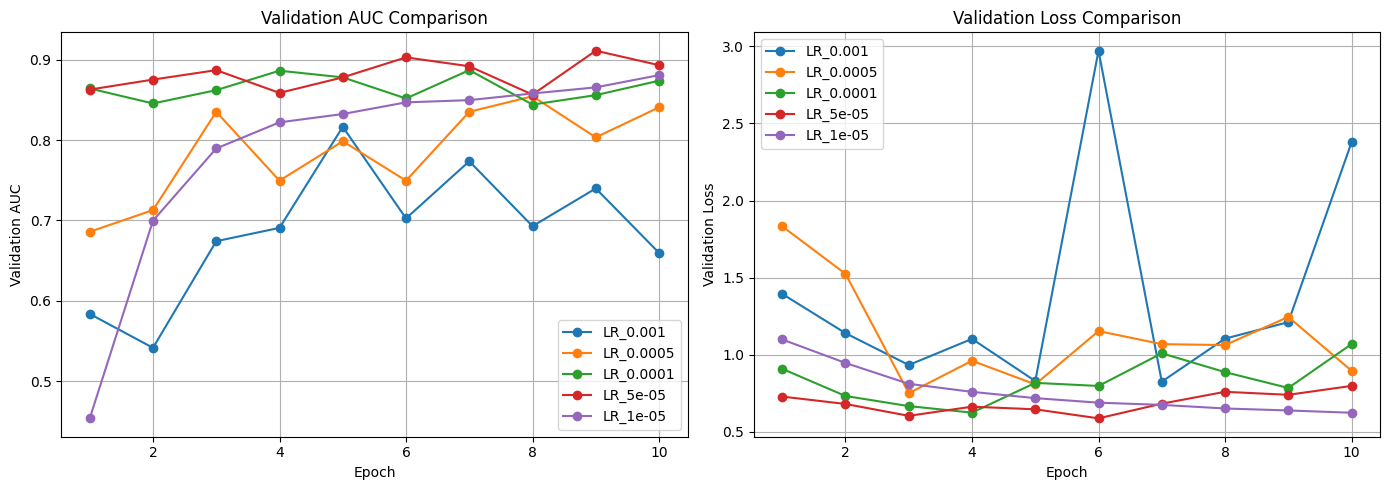

In [16]:
# View results
results_df = runner.get_results_df()
print("\n" + "="*60)
print("Learning Rate Comparison Results")
print("="*60)
display(results_df[['experiment_name', 'learning_rate', 'best_auc', 'best_accuracy']].sort_values('best_auc', ascending=False))

runner.plot_comparison()

---
## 12. Experiment 4: Optimizer Comparison

In [17]:
# Reset runner
runner = ExperimentRunner()

optimizers = [
    ('adam', 1e-4, 0.0),
    ('adamw', 1e-4, 0.01),
    ('sgd', 1e-3, 0.0),
    ('sgd', 1e-3, 1e-4),  # SGD with weight decay
]

for opt_name, lr, wd in optimizers:
    runner.run_experiment(
        experiment_name=f"{opt_name}_lr{lr}_wd{wd}",
        optimizer_name=opt_name,
        learning_rate=lr,
        weight_decay=wd,
        epochs=QUICK_EPOCHS,
        verbose=True
    )

Using device: cuda

Experiment: adam_lr0.0001_wd0.0
Epoch 01 | Train Loss: 0.8637 | Val Loss: 0.9092 | Val AUC: 0.8378 | Val Acc: 0.7907
Epoch 02 | Train Loss: 0.4886 | Val Loss: 0.7923 | Val AUC: 0.8406 | Val Acc: 0.8372
Epoch 03 | Train Loss: 0.2999 | Val Loss: 0.7236 | Val AUC: 0.9013 | Val Acc: 0.8256
Epoch 04 | Train Loss: 0.2437 | Val Loss: 0.9538 | Val AUC: 0.8420 | Val Acc: 0.8140
Epoch 05 | Train Loss: 0.2498 | Val Loss: 0.7486 | Val AUC: 0.8627 | Val Acc: 0.8372
Epoch 06 | Train Loss: 0.2371 | Val Loss: 0.7110 | Val AUC: 0.8668 | Val Acc: 0.7442
Epoch 07 | Train Loss: 0.2041 | Val Loss: 0.6523 | Val AUC: 0.8792 | Val Acc: 0.8140
Epoch 08 | Train Loss: 0.1158 | Val Loss: 1.0844 | Val AUC: 0.8302 | Val Acc: 0.8256
Epoch 09 | Train Loss: 0.0706 | Val Loss: 0.8456 | Val AUC: 0.8703 | Val Acc: 0.8372
Epoch 10 | Train Loss: 0.1114 | Val Loss: 0.9298 | Val AUC: 0.9124 | Val Acc: 0.8605

✅ Best AUC: 0.9124 at epoch 10

Experiment: adamw_lr0.0001_wd0.01
Epoch 01 | Train Loss: 0.9041 |


Optimizer Comparison Results


,experiment_name,optimizer,learning_rate,weight_decay,best_auc,best_accuracy
1,adamw_lr0.0001_wd0.01,adamw,0.0001,0.0100,0.930987,0.860465
0,adam_lr0.0001_wd0.0,adam,0.0001,0.0000,0.912353,0.860465
2,sgd_lr0.001_wd0.0,sgd,0.0010,0.0000,0.897861,0.837209
3,sgd_lr0.001_wd0.0001,sgd,0.0010,0.0001,0.890959,0.872093


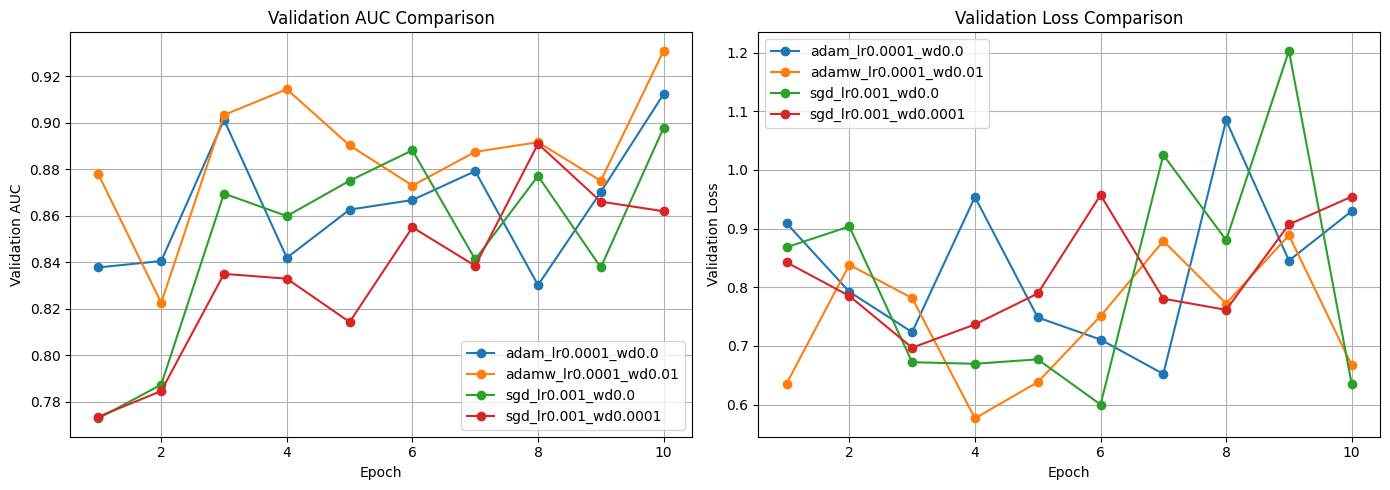

In [18]:
# View results
results_df = runner.get_results_df()
print("\n" + "="*60)
print("Optimizer Comparison Results")
print("="*60)
display(results_df[['experiment_name', 'optimizer', 'learning_rate', 'weight_decay', 'best_auc', 'best_accuracy']].sort_values('best_auc', ascending=False))

runner.plot_comparison()

---
## 13. Experiment 5: Data Augmentation Strategies

In [20]:
# Reset runner
runner = ExperimentRunner()

# Different augmentation configurations
augmentation_configs = [
    {'name': 'baseline', 'h_flip': True, 'v_flip': False, 'rotation': 0},
    {'name': 'with_vflip', 'h_flip': True, 'v_flip': True, 'rotation': 0},
    {'name': 'with_rotation_15', 'h_flip': True, 'v_flip': False, 'rotation': 15},
    {'name': 'with_rotation_30', 'h_flip': True, 'v_flip': False, 'rotation': 30},
    {'name': 'full_augmentation', 'h_flip': True, 'v_flip': True, 'rotation': 15},
    {'name': 'no_augmentation', 'h_flip': False, 'v_flip': False, 'rotation': 0},
]

for config in augmentation_configs:
    runner.run_experiment(
        experiment_name=f"aug_{config['name']}",
        horizontal_flip=config['h_flip'],
        vertical_flip=config['v_flip'],
        rotation_degrees=config['rotation'],
        epochs=5,
        verbose=True
    )

Using device: cuda

Experiment: aug_baseline
Epoch 01 | Train Loss: 0.8892 | Val Loss: 0.8270 | Val AUC: 0.8261 | Val Acc: 0.7791
Epoch 02 | Train Loss: 0.4945 | Val Loss: 1.0896 | Val AUC: 0.8385 | Val Acc: 0.7558
Epoch 03 | Train Loss: 0.3460 | Val Loss: 0.6121 | Val AUC: 0.9006 | Val Acc: 0.8256
Epoch 04 | Train Loss: 0.2964 | Val Loss: 0.7532 | Val AUC: 0.8854 | Val Acc: 0.8605
Epoch 05 | Train Loss: 0.2020 | Val Loss: 0.8653 | Val AUC: 0.8765 | Val Acc: 0.8140

✅ Best AUC: 0.9006 at epoch 3

Experiment: aug_with_vflip
Epoch 01 | Train Loss: 0.9282 | Val Loss: 0.8505 | Val AUC: 0.8109 | Val Acc: 0.8023
Epoch 02 | Train Loss: 0.7813 | Val Loss: 0.7670 | Val AUC: 0.8061 | Val Acc: 0.7442
Epoch 03 | Train Loss: 0.5962 | Val Loss: 0.7613 | Val AUC: 0.8295 | Val Acc: 0.7907
Epoch 04 | Train Loss: 0.5338 | Val Loss: 0.7927 | Val AUC: 0.8012 | Val Acc: 0.6628
Epoch 05 | Train Loss: 0.3913 | Val Loss: 0.7316 | Val AUC: 0.8565 | Val Acc: 0.8023

✅ Best AUC: 0.8565 at epoch 5

Experiment: au


Data Augmentation Comparison Results


,experiment_name,horizontal_flip,vertical_flip,rotation_degrees,best_auc,best_accuracy
5,aug_no_augmentation,False,False,0,0.922015,0.848837
2,aug_with_rotation_15,True,False,15,0.910283,0.872093
3,aug_with_rotation_30,True,False,30,0.908903,0.860465
0,aug_baseline,True,False,0,0.900621,0.825581
4,aug_full_augmentation,True,True,15,0.873706,0.767442
1,aug_with_vflip,True,True,0,0.856453,0.802326


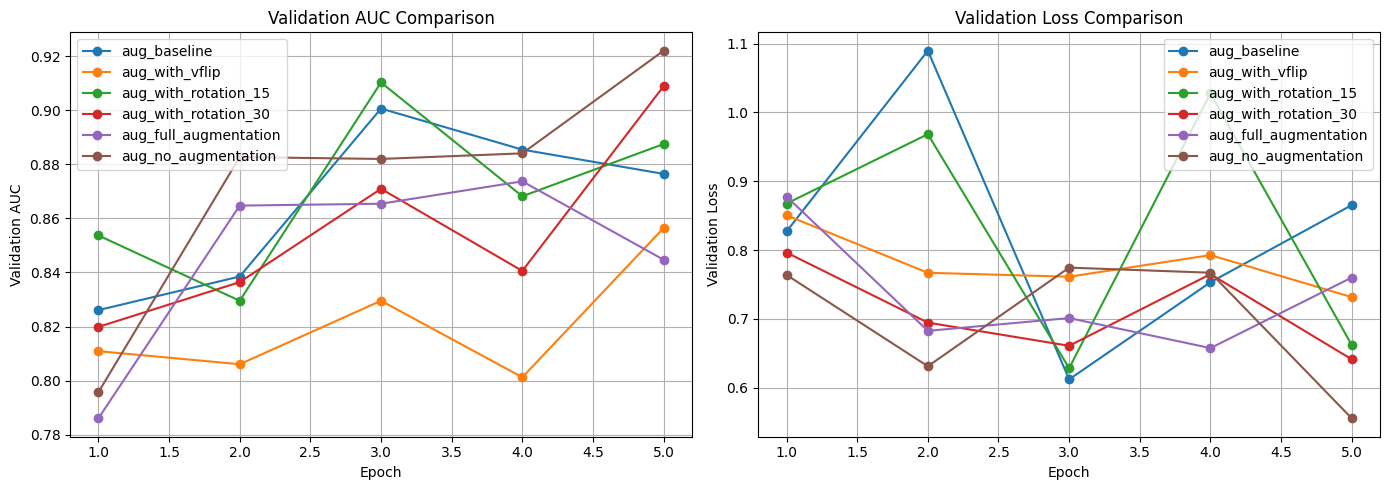

In [21]:
# View results
results_df = runner.get_results_df()
print("\n" + "="*60)
print("Data Augmentation Comparison Results")
print("="*60)
display(results_df[['experiment_name', 'horizontal_flip', 'vertical_flip', 'rotation_degrees', 'best_auc', 'best_accuracy']].sort_values('best_auc', ascending=False))

runner.plot_comparison()

---
## 14. Experiment 6: Model Architecture Comparison

In [22]:
# Reset runner
runner = ExperimentRunner()

models_to_test = ['resnet18', 'resnet34', 'resnet50']

for model_name in models_to_test:
    runner.run_experiment(
        experiment_name=f"model_{model_name}",
        model_name=model_name,
        epochs=QUICK_EPOCHS,
        verbose=True
    )

Using device: cuda

Experiment: model_resnet18
Epoch 01 | Train Loss: 0.9028 | Val Loss: 0.8566 | Val AUC: 0.8116 | Val Acc: 0.8256
Epoch 02 | Train Loss: 0.5817 | Val Loss: 0.7307 | Val AUC: 0.8309 | Val Acc: 0.6744
Epoch 03 | Train Loss: 0.3623 | Val Loss: 0.6670 | Val AUC: 0.9089 | Val Acc: 0.8488
Epoch 04 | Train Loss: 0.2385 | Val Loss: 0.7963 | Val AUC: 0.8571 | Val Acc: 0.7907
Epoch 05 | Train Loss: 0.1960 | Val Loss: 0.7675 | Val AUC: 0.8668 | Val Acc: 0.8372
Epoch 06 | Train Loss: 0.1982 | Val Loss: 0.9481 | Val AUC: 0.8413 | Val Acc: 0.8372
Epoch 07 | Train Loss: 0.2018 | Val Loss: 0.8700 | Val AUC: 0.8951 | Val Acc: 0.8605
Epoch 08 | Train Loss: 0.0816 | Val Loss: 0.9217 | Val AUC: 0.8571 | Val Acc: 0.8140
Epoch 09 | Train Loss: 0.1590 | Val Loss: 0.8372 | Val AUC: 0.8682 | Val Acc: 0.7907
Epoch 10 | Train Loss: 0.1443 | Val Loss: 0.6971 | Val AUC: 0.8778 | Val Acc: 0.7791

✅ Best AUC: 0.9089 at epoch 3

Experiment: model_resnet34


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\HP/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:07<00:00, 12.1MB/s]


Epoch 01 | Train Loss: 0.9144 | Val Loss: 0.9246 | Val AUC: 0.8157 | Val Acc: 0.7558
Epoch 02 | Train Loss: 0.4566 | Val Loss: 0.6658 | Val AUC: 0.8502 | Val Acc: 0.7674
Epoch 03 | Train Loss: 0.3953 | Val Loss: 0.9273 | Val AUC: 0.8026 | Val Acc: 0.8256
Epoch 04 | Train Loss: 0.2724 | Val Loss: 0.6662 | Val AUC: 0.8972 | Val Acc: 0.8372
Epoch 05 | Train Loss: 0.1407 | Val Loss: 1.0027 | Val AUC: 0.8330 | Val Acc: 0.8023
Epoch 06 | Train Loss: 0.2034 | Val Loss: 1.2485 | Val AUC: 0.8192 | Val Acc: 0.7093
Epoch 07 | Train Loss: 0.2833 | Val Loss: 0.7306 | Val AUC: 0.8896 | Val Acc: 0.8140
Epoch 08 | Train Loss: 0.1885 | Val Loss: 0.8917 | Val AUC: 0.8551 | Val Acc: 0.8488
Epoch 09 | Train Loss: 0.1235 | Val Loss: 0.7189 | Val AUC: 0.8916 | Val Acc: 0.8372
Epoch 10 | Train Loss: 0.1621 | Val Loss: 0.8271 | Val AUC: 0.8813 | Val Acc: 0.7093

✅ Best AUC: 0.8972 at epoch 4

Experiment: model_resnet50


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\HP/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:08<00:00, 12.7MB/s]


Epoch 01 | Train Loss: 0.8644 | Val Loss: 0.7145 | Val AUC: 0.8454 | Val Acc: 0.8488
Epoch 02 | Train Loss: 0.4775 | Val Loss: 0.7019 | Val AUC: 0.9096 | Val Acc: 0.7791
Epoch 03 | Train Loss: 0.4834 | Val Loss: 0.6512 | Val AUC: 0.8799 | Val Acc: 0.8140
Epoch 04 | Train Loss: 0.2575 | Val Loss: 0.7065 | Val AUC: 0.8703 | Val Acc: 0.8256
Epoch 05 | Train Loss: 0.2380 | Val Loss: 0.8953 | Val AUC: 0.8592 | Val Acc: 0.8605
Epoch 06 | Train Loss: 0.2128 | Val Loss: 0.8405 | Val AUC: 0.8841 | Val Acc: 0.8372
Epoch 07 | Train Loss: 0.2358 | Val Loss: 0.6706 | Val AUC: 0.8772 | Val Acc: 0.8256
Epoch 08 | Train Loss: 0.1464 | Val Loss: 0.9019 | Val AUC: 0.8558 | Val Acc: 0.8256
Epoch 09 | Train Loss: 0.1929 | Val Loss: 0.8204 | Val AUC: 0.9082 | Val Acc: 0.8837
Epoch 10 | Train Loss: 0.1643 | Val Loss: 0.5798 | Val AUC: 0.9213 | Val Acc: 0.8837

✅ Best AUC: 0.9213 at epoch 10



Model Architecture Comparison Results


,experiment_name,model_name,best_auc,best_accuracy
2,model_resnet50,resnet50,0.921325,0.883721
0,model_resnet18,resnet18,0.908903,0.848837
1,model_resnet34,resnet34,0.897170,0.837209


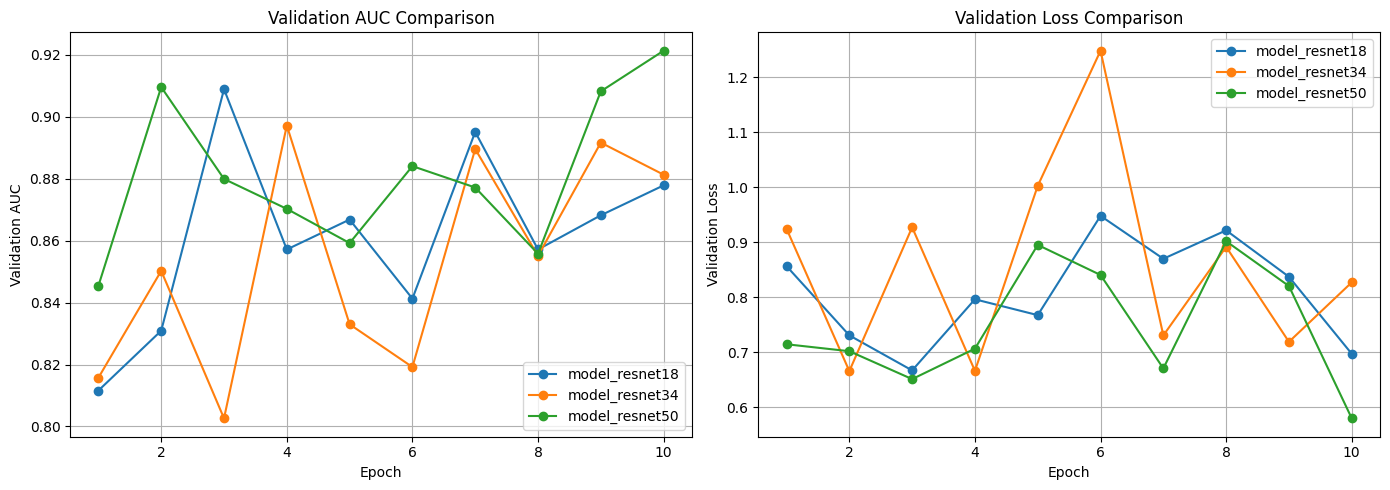

In [23]:
# View results
results_df = runner.get_results_df()
print("\n" + "="*60)
print("Model Architecture Comparison Results")
print("="*60)
display(results_df[['experiment_name', 'model_name', 'best_auc', 'best_accuracy']].sort_values('best_auc', ascending=False))

runner.plot_comparison()

---
## 15. Experiment 7: Batch Size Comparison

In [24]:
# Reset runner
runner = ExperimentRunner()

batch_sizes = [8, 16, 32]

for bs in batch_sizes:
    runner.run_experiment(
        experiment_name=f"batch_size_{bs}",
        batch_size=bs,
        epochs=QUICK_EPOCHS,
        verbose=True
    )

Using device: cuda

Experiment: batch_size_8
Epoch 01 | Train Loss: 0.9053 | Val Loss: 1.1776 | Val AUC: 0.7888 | Val Acc: 0.7558
Epoch 02 | Train Loss: 0.6388 | Val Loss: 0.9565 | Val AUC: 0.7909 | Val Acc: 0.6628
Epoch 03 | Train Loss: 0.5126 | Val Loss: 1.0805 | Val AUC: 0.8351 | Val Acc: 0.8372
Epoch 04 | Train Loss: 0.3611 | Val Loss: 0.8887 | Val AUC: 0.8109 | Val Acc: 0.7093
Epoch 05 | Train Loss: 0.2780 | Val Loss: 0.7807 | Val AUC: 0.8634 | Val Acc: 0.8372
Epoch 06 | Train Loss: 0.3421 | Val Loss: 0.8415 | Val AUC: 0.8275 | Val Acc: 0.7674
Epoch 07 | Train Loss: 0.2462 | Val Loss: 0.8211 | Val AUC: 0.8944 | Val Acc: 0.8256
Epoch 08 | Train Loss: 0.1660 | Val Loss: 0.7969 | Val AUC: 0.8834 | Val Acc: 0.8372
Epoch 09 | Train Loss: 0.2506 | Val Loss: 0.9519 | Val AUC: 0.8171 | Val Acc: 0.6977
Epoch 10 | Train Loss: 0.2470 | Val Loss: 0.8969 | Val AUC: 0.8668 | Val Acc: 0.8256

✅ Best AUC: 0.8944 at epoch 7

Experiment: batch_size_16
Epoch 01 | Train Loss: 0.8646 | Val Loss: 0.801


Batch Size Comparison Results


,experiment_name,batch_size,best_auc,best_accuracy
2,batch_size_32,32,0.931677,0.895349
0,batch_size_8,8,0.894410,0.825581
1,batch_size_16,16,0.886818,0.813953


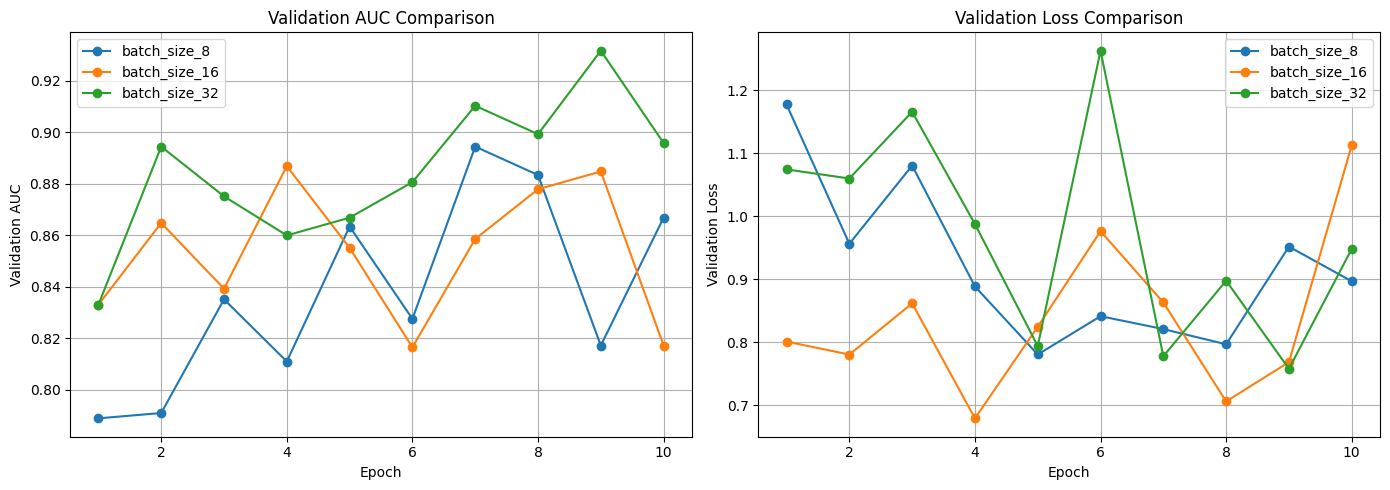

In [25]:
# View results
results_df = runner.get_results_df()
print("\n" + "="*60)
print("Batch Size Comparison Results")
print("="*60)
display(results_df[['experiment_name', 'batch_size', 'best_auc', 'best_accuracy']].sort_values('best_auc', ascending=False))

runner.plot_comparison()

---
## 16. Run Your Own Custom Experiment

Use this cell to configure and run your own custom experiment.

In [31]:
# =============================================================================
# CUSTOM EXPERIMENT CONFIGURATION
# Modify these parameters to run your own experiment
# =============================================================================

custom_runner = ExperimentRunner()

result = custom_runner.run_experiment(
    experiment_name="my_custom_experiment",
    
    # CLAHE Parameters
    clahe_clip_limit=2.0,        # Try: 1.0, 2.0, 3.0, 4.0, 5.0
    clahe_tile_grid=(16, 16),      # Try: (4,4), (8,8), (16,16)
    clahe_channel='luminance',       # Try: 'green', 'luminance', 'all'
    use_clahe=True,              # Try: True, False
    
    # Model Parameters
    model_name='resnet50',       # Try: 'resnet18', 'resnet34', 'resnet50'
    pretrained=True,
    freeze_backbone=False,       # Try: True for transfer learning
    
    # Training Parameters
    batch_size=32,               # Try: 8, 16, 32
    learning_rate=5e-5,          # Try: 1e-3, 5e-4, 1e-4, 5e-5
    optimizer_name='adamw',       # Try: 'adam', 'adamw', 'sgd'
    weight_decay=0.0,            # Try: 0.0, 1e-4, 1e-3, 0.01
    epochs=10,                   # More epochs for better results
    scheduler_name=None,         # Try: None, 'step', 'cosine', 'plateau'
    
    # Augmentation Parameters
    image_size=224,              # Try: 224, 256, 299
    horizontal_flip=True,
    vertical_flip=False,
    rotation_degrees=15,          # Try: 0, 10, 15, 30
    
    # Loss Parameters
    use_pos_weight=True,         # Handle class imbalance
    pos_weight_multiplier=1.0,   # Try: 0.5, 1.0, 1.5, 2.0
    
    verbose=True
)

print("\n" + "="*60)
print("Custom Experiment Results:")
print(f"Best AUC: {result['best_auc']:.4f}")
print(f"Best Accuracy: {result['best_accuracy']:.4f}")
print(f"Best F1: {result['best_f1']:.4f}")
print(f"Best Epoch: {result['best_epoch']}")
print("="*60)

Using device: cuda

Experiment: my_custom_experiment
Epoch 01 | Train Loss: 0.9218 | Val Loss: 0.9393 | Val AUC: 0.8268 | Val Acc: 0.7907
Epoch 02 | Train Loss: 0.7267 | Val Loss: 0.7725 | Val AUC: 0.8433 | Val Acc: 0.8256
Epoch 03 | Train Loss: 0.5149 | Val Loss: 0.7158 | Val AUC: 0.8854 | Val Acc: 0.7907
Epoch 04 | Train Loss: 0.3536 | Val Loss: 0.8924 | Val AUC: 0.8468 | Val Acc: 0.7907
Epoch 05 | Train Loss: 0.2166 | Val Loss: 0.6998 | Val AUC: 0.8951 | Val Acc: 0.8256
Epoch 06 | Train Loss: 0.1931 | Val Loss: 0.7819 | Val AUC: 0.9013 | Val Acc: 0.8605
Epoch 07 | Train Loss: 0.1970 | Val Loss: 1.2289 | Val AUC: 0.8578 | Val Acc: 0.8023
Epoch 08 | Train Loss: 0.1193 | Val Loss: 1.0988 | Val AUC: 0.8930 | Val Acc: 0.8488
Epoch 09 | Train Loss: 0.1812 | Val Loss: 0.7828 | Val AUC: 0.9186 | Val Acc: 0.8372
Epoch 10 | Train Loss: 0.0844 | Val Loss: 0.6739 | Val AUC: 0.9144 | Val Acc: 0.8372

✅ Best AUC: 0.9186 at epoch 9

Custom Experiment Results:
Best AUC: 0.9186
Best Accuracy: 0.8372

In [36]:
# =============================================================================
# CUSTOM EXPERIMENT CONFIGURATION
# Modify these parameters to run your own experiment
# =============================================================================

custom_runner = ExperimentRunner()

result = custom_runner.run_experiment(
    experiment_name="my_custom_experiment_2",
    
    # CLAHE Parameters
    clahe_clip_limit=2.0,        # Try: 1.0, 2.0, 3.0, 4.0, 5.0
    clahe_tile_grid=(16, 16),      # Try: (4,4), (8,8), (16,16)
    clahe_channel='green',       # Try: 'green', 'luminance', 'all'
    use_clahe=True,              # Try: True, False
    
    # Model Parameters
    model_name='resnet18',       # Try: 'resnet18', 'resnet34', 'resnet50'
    pretrained=True,
    freeze_backbone=False,       # Try: True for transfer learning
    
    # Training Parameters
    batch_size=32,               # Try: 8, 16, 32
    learning_rate=5e-5,          # Try: 1e-3, 5e-4, 1e-4, 5e-5
    optimizer_name='adamw',       # Try: 'adam', 'adamw', 'sgd'
    weight_decay=0.0,            # Try: 0.0, 1e-4, 1e-3, 0.01
    epochs=50,                   # More epochs for better results
    scheduler_name=None,         # Try: None, 'step', 'cosine', 'plateau'
    
    # Augmentation Parameters
    image_size=224,              # Try: 224, 256, 299
    horizontal_flip=True,
    vertical_flip=False,
    rotation_degrees=15,          # Try: 0, 10, 15, 30
    
    # Loss Parameters
    use_pos_weight=True,         # Handle class imbalance
    pos_weight_multiplier=1.0,   # Try: 0.5, 1.0, 1.5, 2.0
    
    verbose=True
)

print("\n" + "="*60)
print("Custom Experiment Results:")
print(f"Best AUC: {result['best_auc']:.4f}")
print(f"Best Accuracy: {result['best_accuracy']:.4f}")
print(f"Best F1: {result['best_f1']:.4f}")
print(f"Best Epoch: {result['best_epoch']}")
print("="*60)

Using device: cuda

Experiment: my_custom_experiment_2
Epoch 01 | Train Loss: 0.9982 | Val Loss: 0.9491 | Val AUC: 0.7833 | Val Acc: 0.7907
Epoch 02 | Train Loss: 0.7220 | Val Loss: 0.8079 | Val AUC: 0.8544 | Val Acc: 0.7791
Epoch 03 | Train Loss: 0.5814 | Val Loss: 0.6960 | Val AUC: 0.8813 | Val Acc: 0.8023
Epoch 04 | Train Loss: 0.4768 | Val Loss: 0.6280 | Val AUC: 0.8986 | Val Acc: 0.8140
Epoch 05 | Train Loss: 0.4170 | Val Loss: 0.6267 | Val AUC: 0.9296 | Val Acc: 0.8372
Epoch 06 | Train Loss: 0.3293 | Val Loss: 0.7316 | Val AUC: 0.8992 | Val Acc: 0.8488
Epoch 07 | Train Loss: 0.2810 | Val Loss: 0.6414 | Val AUC: 0.9034 | Val Acc: 0.8721
Epoch 08 | Train Loss: 0.2497 | Val Loss: 0.7482 | Val AUC: 0.8765 | Val Acc: 0.8721
Epoch 09 | Train Loss: 0.2314 | Val Loss: 0.7457 | Val AUC: 0.8992 | Val Acc: 0.7907
Epoch 10 | Train Loss: 0.2160 | Val Loss: 0.8258 | Val AUC: 0.8682 | Val Acc: 0.8256
Epoch 11 | Train Loss: 0.1663 | Val Loss: 0.7666 | Val AUC: 0.8916 | Val Acc: 0.8256
Epoch 12 |

---
## 17. Summary: Find Best Configuration

Compare all experiments and find the best configuration.

In [28]:
# Collect all results from different experiment sets
# You can manually add results from different runs here

print("\n" + "="*70)
print("EXPERIMENT SUMMARY")
print("="*70)
print("\nRecommended next steps:")
print("1. Run CLAHE clip limit experiments to find optimal value")
print("2. Compare CLAHE channels (green vs luminance vs all)")
print("3. Test different learning rates")
print("4. Experiment with data augmentation")
print("5. Try different model architectures")
print("6. Run final training with best config for more epochs")
print("\nTip: Start with quick 5-epoch experiments, then run longer")
print("training with the best configuration.")


EXPERIMENT SUMMARY

Recommended next steps:
1. Run CLAHE clip limit experiments to find optimal value
2. Compare CLAHE channels (green vs luminance vs all)
3. Test different learning rates
4. Experiment with data augmentation
5. Try different model architectures
6. Run final training with best config for more epochs

Tip: Start with quick 5-epoch experiments, then run longer
training with the best configuration.


---
## 18. Save Best Model Configuration

In [32]:
# After finding the best configuration, save it
import json

best_config = {
    "clahe_clip_limit": 2.0,
    "clahe_tile_grid": [16, 16],
    "clahe_channel": "luminance",
    "use_clahe": True,
    "model_name": "resnet18",
    "batch_size": 32,
    "learning_rate": 5e-5,
    "optimizer": "adamw",
    "weight_decay": 0.0,
    "epochs": 50,
    "image_size": 224,
    "horizontal_flip": True,
    "vertical_flip": False,
    "rotation_degrees": 15,
}

# Save configuration
config_path = PROJECT_ROOT / "best_config.json"
with open(config_path, 'w') as f:
    json.dump(best_config, f, indent=2)

print(f"Configuration saved to: {config_path}")
print("\nUpdate these values after running experiments!")

Configuration saved to: c:\Users\HP\Desktop\ROPDetectionAIML\best_config.json

Update these values after running experiments!
